In [1]:
import numpy as np

# Motivation

The motivation of this notebook can be described as "avoid duplicate code". I am exploring ways to make `poliastro.core` generic in such a way that it compiles for different targets with just a single code base. As a part of that, I want to make it work on both scalars and arrays without sacrificing significant amounts performance. If, on the other hand, overall performance increases across all targets, hey, even better.

1) How much does the code actually need to change? `numpy` stuff, data structures ...
2) How much does performance change?

# Here is what `poliastro` does at the moment ...

It heavily relies on `numpy` functions and tosses `ndarray` objects around. The notation is easy and readable. 

`test_arraystyle` is a dummy test function while `eccentricity_vector` can actually found in `poliastro`.

In [2]:
from numba import njit, vectorize

@njit
def norm(arr):
    return np.sqrt(arr @ arr)

@njit
def eccentricity_vector(k, r, v):
    return ((v @ v - k / norm(r)) * r - (r @ v) * v) / k

@vectorize('f8(f8)', target = 'cpu', nopython = True)
def test_arraystyle(d):
    return np.sum(eccentricity_vector(d, np.array([d + 1, d + 2, + 3]), np.array([d + 4, d + 5, d + 6])))

# Here is what `poliastro` could be doing ...

Baseline: A number of `numpy` functions have to go. Most can be substituted rather easily. Besides, and this is a little more work, the core data structures for vectors (and matrices) in *helper functions* have to shift from little `ndarray` objects to "good old" tuples. Yes, immutable Python tuples, you have read correctly.

Notice that there are two new `jit` decorators, located in `poliastro.core.jit`, currently obtainable from [this commit](https://github.com/s-m-e/poliastro/tree/2552390f2e53f23fb990ee97b651ecb13ce24f3a). They handle target switching, inlining and expansion of otherwise stupid long signatures (`V` for instance expands to `["Tuple([f4,f4,f4])", "Tuple([f8,f8,f8])"]`), among other annoyances. Note that on the `cpu` target, type interference is mostly good without signatures. This pictures begins to shift on the `parallel` target and outright breaks down on the `cuda` target where stuff usually does not compile at all without them.

In [3]:
from math import sqrt  # Almost all basic math has to be shifted to `math`
import os

# POLIASTRO_TARGET can be set to `cpu`, `parallel` or `cuda`. Default: `cpu`
os.environ['POLIASTRO_TARGET'] = 'cpu'  

# POLIASTRO_INLINE can be set to `always` or `never`. Default: `never`. `always` increases compile time by *a lot* ...
# Does NOT affect cuda target at the moment - helpers should always be inlined there.
os.environ['POLIASTRO_INLINE'] = 'always'

from poliastro.core.jit import vjit, hjit, TARGET, INLINE

print(TARGET, INLINE)  # verfication

cpu always


Just for clarification: `cpu` does not just mean CPU. In means *one single thread*. 

`vjit` is a version of `vectorize`. Functions decorated by it can be called from virtually anywhere. `hjit` is a bit more tricky. It decorates "helpers". Depending on the compiler target, those functions can only be called by other functions decorated by `vjit` or `hjit`. In my example, they carry the suffix `_` (single underscore). They are not necessarily pure scalar functions. It's the fact that they can not be called directly which makes them stand out and lets them require some kind of naming convention. They are really helpers and therefore "core".

In [4]:
@hjit('f(V,V)')
def matmul_(a, b):
    return a[0] * b[0] + a[1] * b[1] + a[2] * b[2]

@hjit('f(V)')
def norm_(a):
    return sqrt(matmul_(a, a))

@hjit('V(f,V,V)')
def eccentricity_vector_(k, r, v):
    a = matmul_(v, v) - k / norm_(r)
    b = matmul_(r, v)
    return (
        (a * r[0] - b * v[0]) / k,
        (a * r[1] - b * v[1]) / k,
        (a * r[2] - b * v[2]) / k,
    )  # no sane way of turning this into a for-loop -> numba bug(s), need to investigate this further

@vjit('f(f)')
def test_tuplestyle(d):
    return sum(eccentricity_vector_(d, (d + 1, d + 2, + 3), (d + 4, d + 5, d + 6)))

## The above in full Haskell-style

The following is more of an academic experiment, trying to work around a `numba` bug (converting a list of floats to a tuple of floats is really a pain in the ****).

In [5]:
@hjit('V(V,f)')
def vs_mul_(v, s):
    return v[0] * s, v[1] * s, v[2] * s

@hjit('V(V,f)')
def vs_div_(v, s):
    return v[0] / s, v[1] / s, v[2] / s

@hjit('V(V,V)')
def vv_sub_(va, vb):
    return va[0] - vb[0], va[1] - vb[1], va[2] - vb[2]

@hjit('V(f,V,V)')
def eccentricity_vector_haskell_(k, r, v):
    a = matmul_(v, v) - k / norm_(r)
    b = matmul_(r, v)
    return vs_div_(vv_sub_(vs_mul_(r, a), vs_mul_(v, b)), k)

@vjit('f(f)')
def test_haskelstyle(d):
    return sum(eccentricity_vector_haskell_(d, (d + 1, d + 2, + 3), (d + 4, d + 5, d + 6)))

# Verification of results

In [6]:
funcs = [
    test_arraystyle,
    test_tuplestyle,
    test_haskelstyle,
]

In [7]:
def test_all(size = 100):
    
    data = np.random.random(size) * 128 + 1
    res_base = funcs[0](data)
    
    for func in funcs[1:]:
        res = func(data)
        assert np.allclose(res_base, res)
        
test_all()

# Benchmark

In [8]:
import gc
from time import time_ns
from tqdm import tqdm

In [9]:
def _name(func):
    try:
        return func.__name__
    except AttributeError:  # numba#8272
        return list(func.functions.values())[0][1].py_func.__name__[13:]

def benchmark(start = 4, stop = 25, reps = 2):  # 25
    sizes = (2 ** np.arange(start, stop + 0.5, 0.5)).astype('i8')
    results = {_name(func): [] for func in funcs}
    gc.disable()
    for size in tqdm(sizes):
        data = np.arange(1, size + 1, 1, dtype = 'f8')
        for func in funcs:
            runtimes = []
            for rep in range(reps):
                assert data.dtype == np.float64
                gc.collect()
                start = time_ns()
                result = func(data)
                runtime = time_ns() - start
                runtimes.append(runtime)
                assert result.dtype == np.float64
            results[_name(func)].append(min(runtimes) * 1e-9)
    gc.enable()
    return sizes, results

s, r = benchmark()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:45<00:00,  1.06s/it]


# Analysis / plots

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

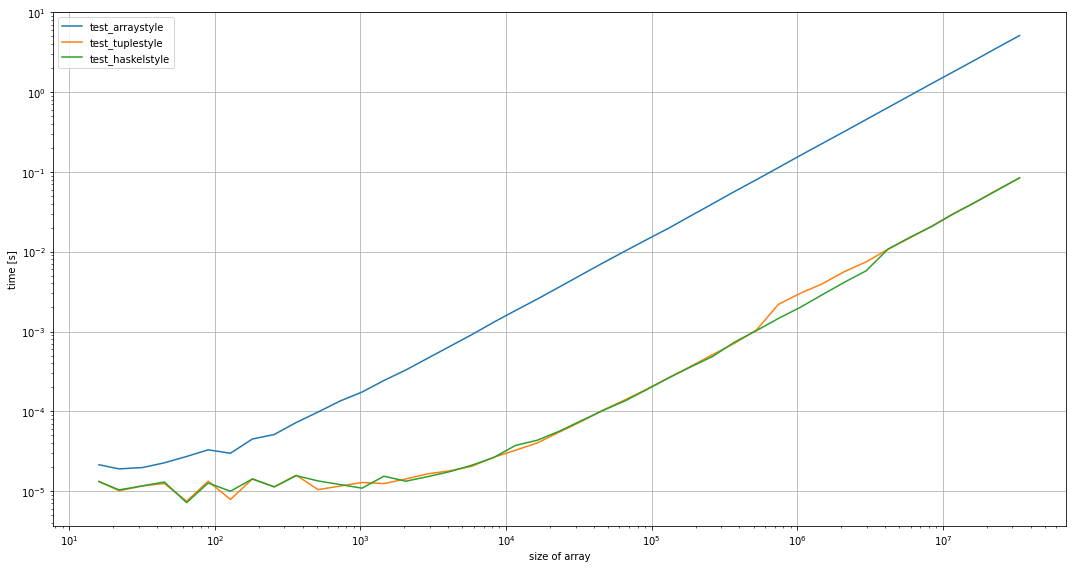

In [11]:
def plot_all(sizes, results):
    fig, ax = plt.subplots(figsize = (15, 8))
    for name, values in results.items():
        ax.loglog(sizes, values, label = name)
    ax.legend()
    ax.set_xlabel('size of array')
    ax.set_ylabel('time [s]')
    ax.grid()
    fig.tight_layout()
    fig.savefig('plot_all.jpg')

plot_all(s, r)

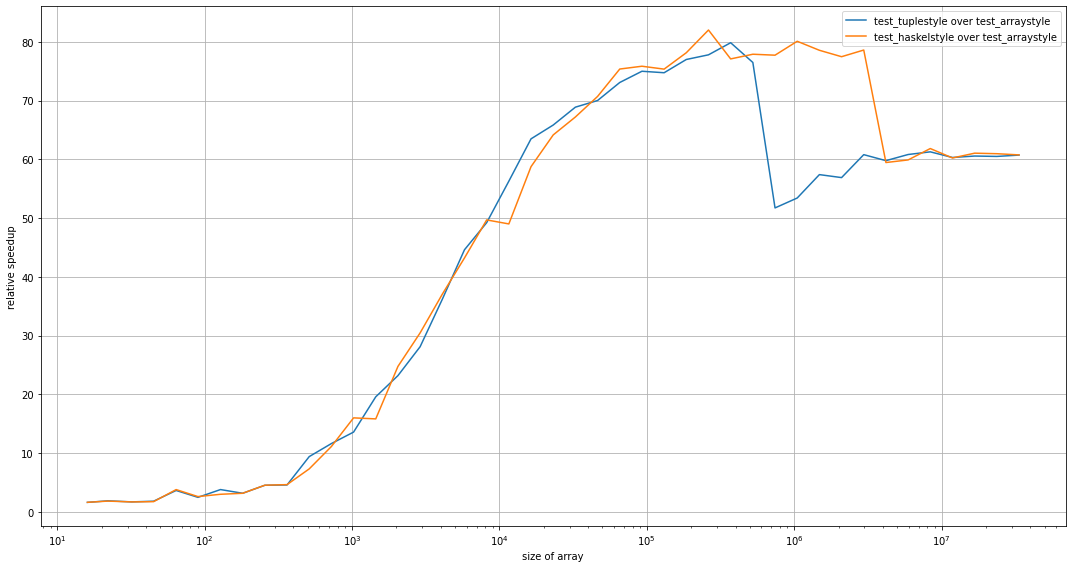

In [12]:
def plot_relative_speedup(sizes, results, pairs):
    fig, ax = plt.subplots(figsize = (15, 8))
    for base, faster in pairs:
        ax.semilogx(
            sizes,
            np.array(r[base]) / np.array(r[faster]),
            label = f'{faster:s} over {base:}',
        )
    ax.legend()
    ax.set_xlabel('size of array')
    ax.set_ylabel('relative speedup')
    ax.grid()
    fig.tight_layout()
    fig.savefig('plot_relative_speedup.jpg')

plot_relative_speedup(s, r, pairs = [
    ('test_arraystyle', 'test_tuplestyle'),
    ('test_arraystyle', 'test_haskelstyle'),
])

Given the code changes required, the gains may be worth the effort. Without inline, performance gains of a factor of up to 20 can be observed (per single thread). With inline (and ignoring the additional compile time), performance gains of a factor up to 80 (per single thread), depending on the size of input data, can be observed.

**Since some of the effects that cause the above benchmark results are highly dependent on one's type of CPU, I encourage you to repeat this experiment on your own hardware and report back results.**